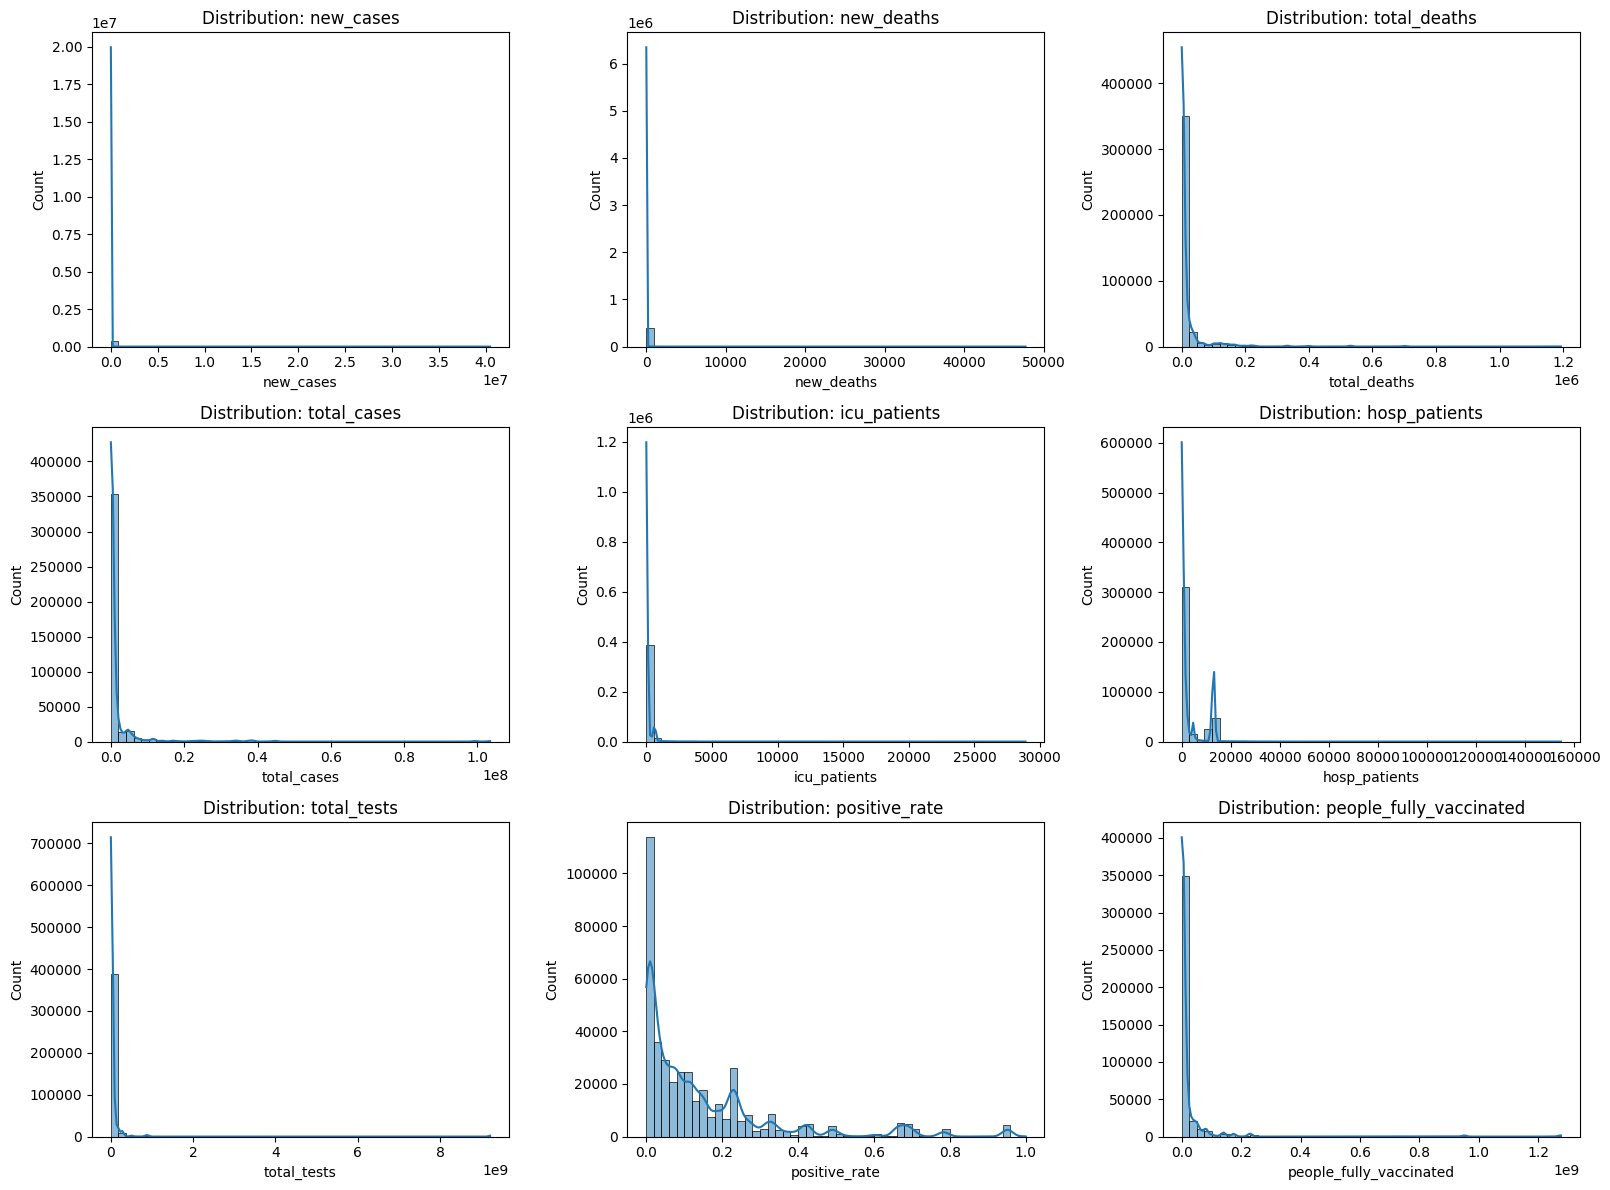

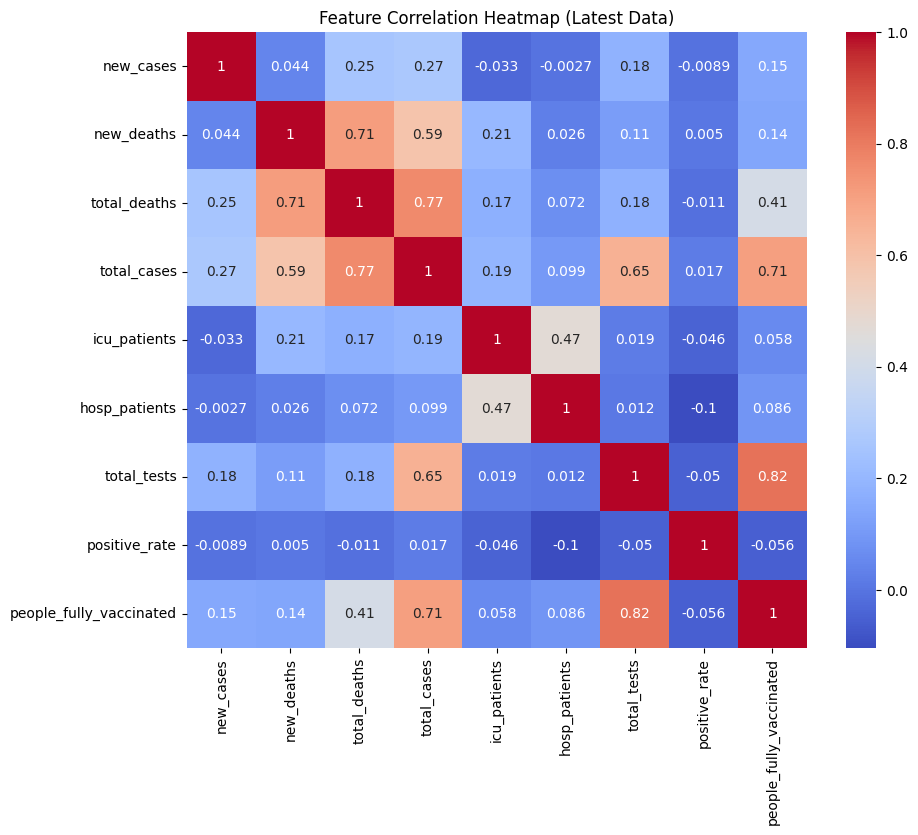

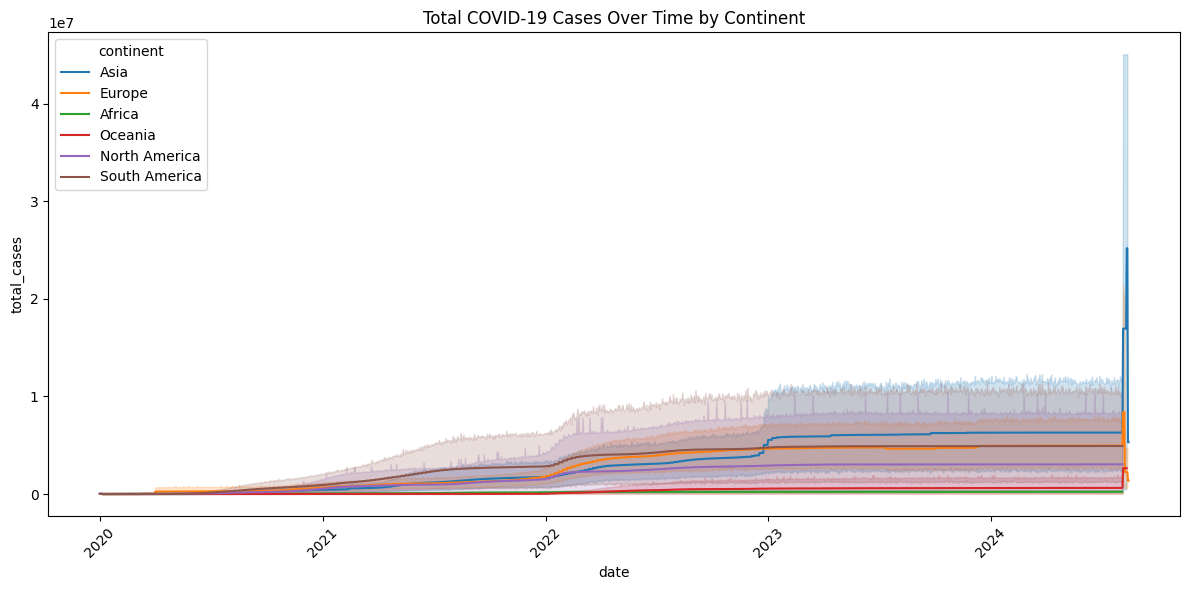

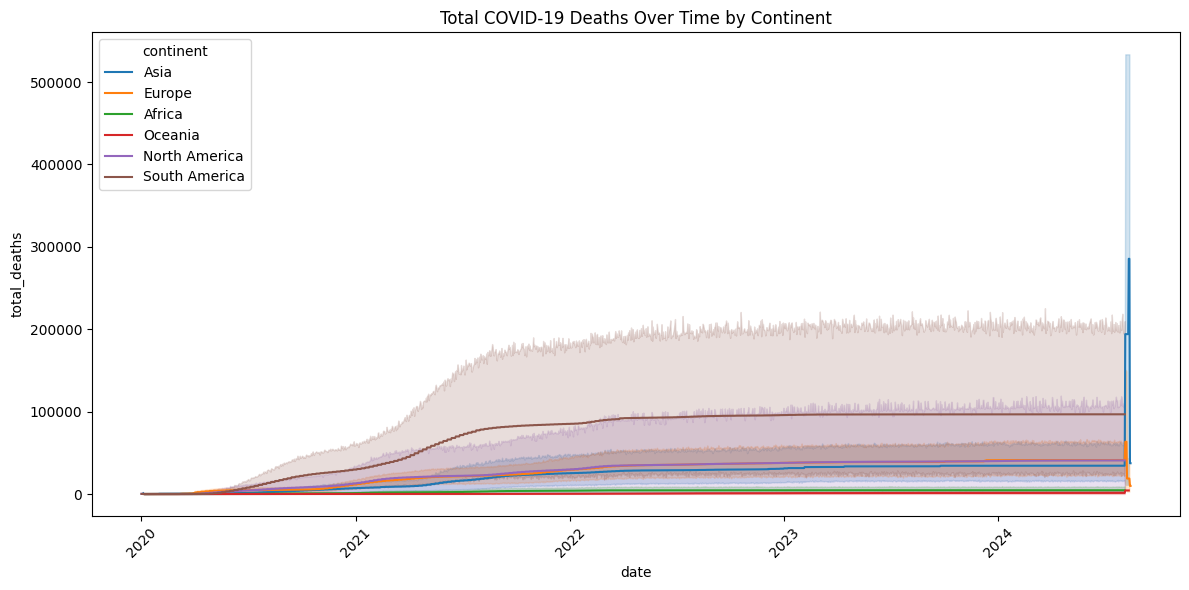

📍 Asia
   Linear Regression RMSE: 7469116.46
   Random Forest RMSE:     4963302.66
   MLP Regressor RMSE:     7739406.80

📍 Europe
   Linear Regression RMSE: 3715082.60
   Random Forest RMSE:     559564.15
   MLP Regressor RMSE:     3945733.87

📍 Africa
   Linear Regression RMSE: 433341.03
   Random Forest RMSE:     59259.74
   MLP Regressor RMSE:     456579.77

📍 Oceania
   Linear Regression RMSE: 1537966.28
   Random Forest RMSE:     133738.41
   MLP Regressor RMSE:     1595771.54

📍 North America
   Linear Regression RMSE: 4769653.63
   Random Forest RMSE:     3448718.69
   MLP Regressor RMSE:     4859028.44

📍 South America
   Linear Regression RMSE: 7113168.33
   Random Forest RMSE:     542083.03
   MLP Regressor RMSE:     7970710.86

       Continent  LinearRegression_RMSE  RandomForest_RMSE      MLP_RMSE
0           Asia           7.469116e+06       4.963303e+06  7.739407e+06
1         Europe           3.715083e+06       5.595641e+05  3.945734e+06
2         Africa           4.33

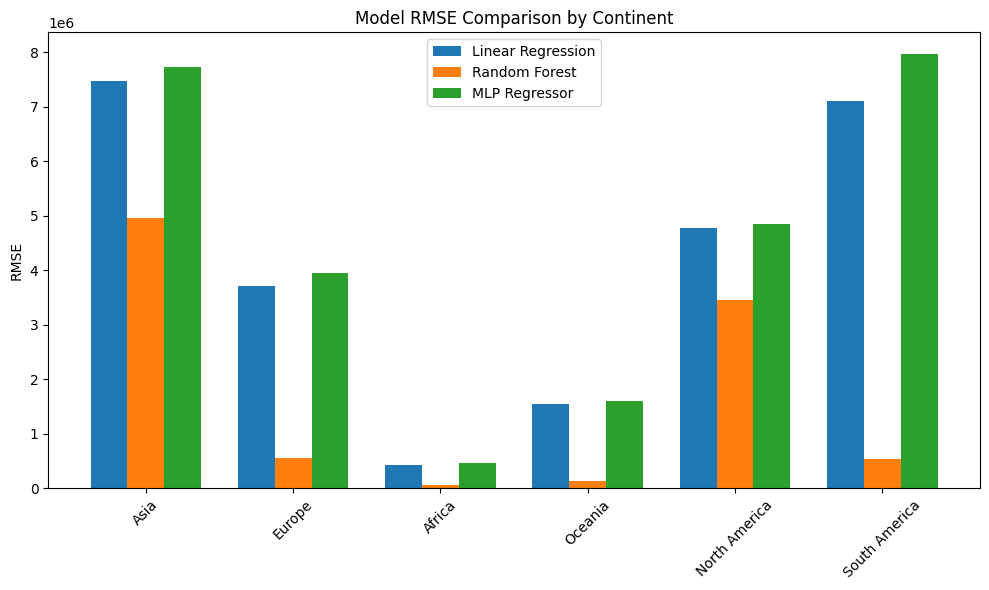

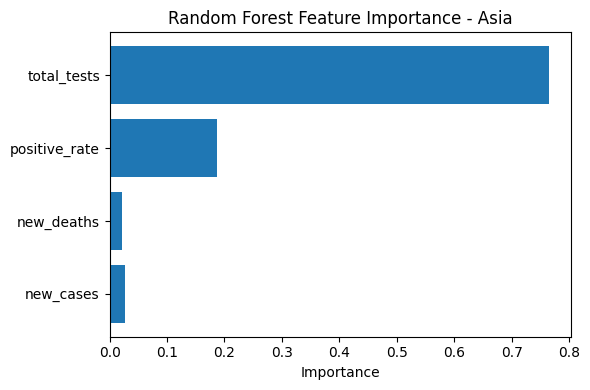

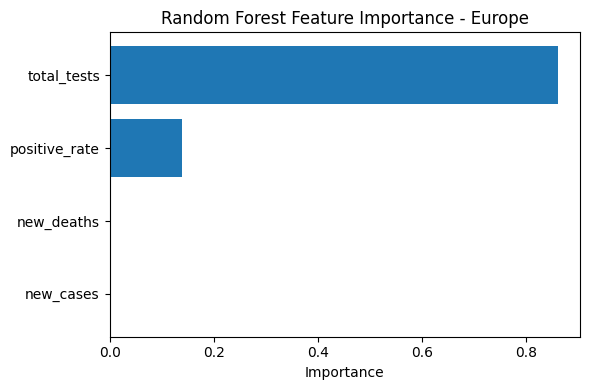

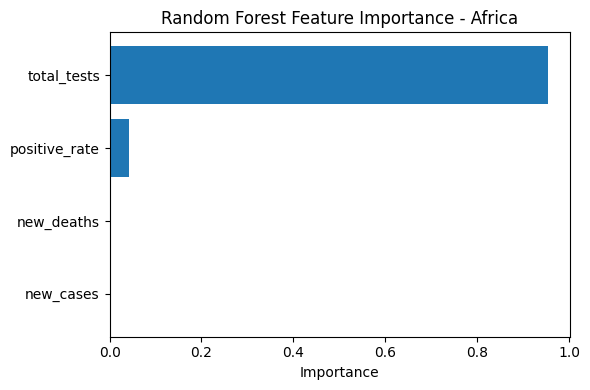

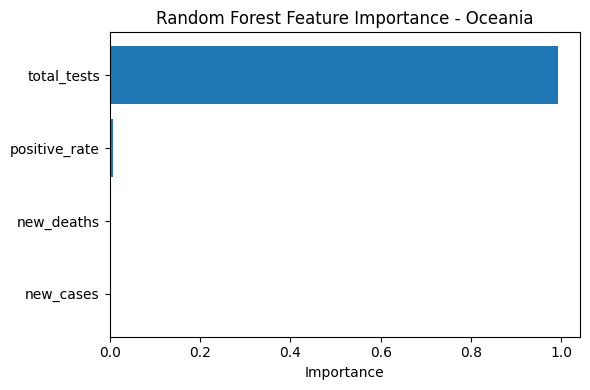

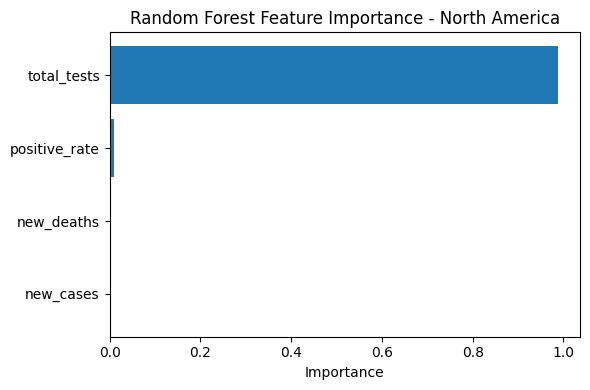

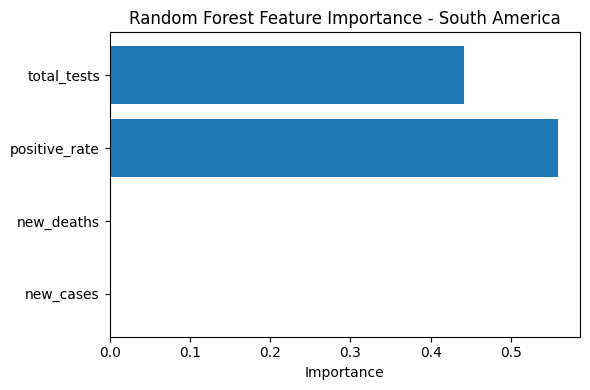

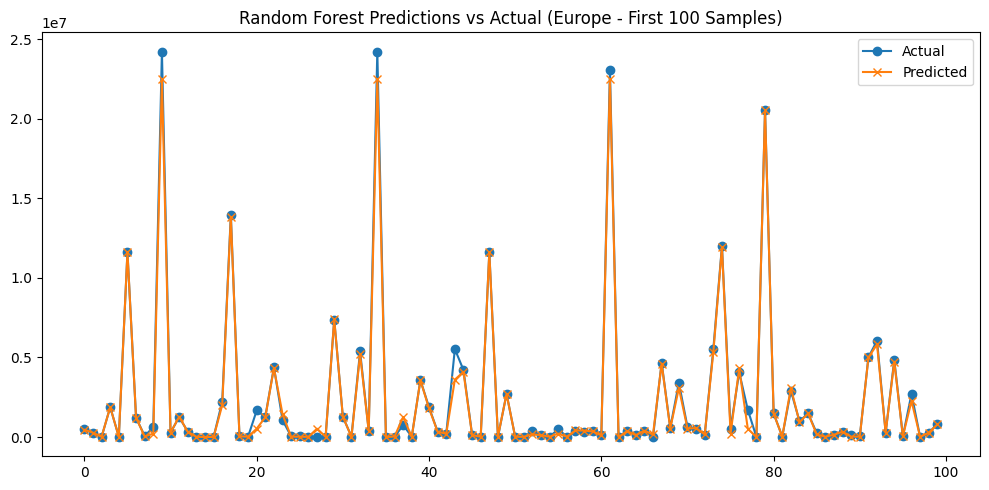

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Directory to save plots
saveDir = "./"  # Change this to a folder path if desired

covidData = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
covidData = covidData[covidData['continent'].notna()]
covidData['date'] = pd.to_datetime(covidData['date'])
covidData.fillna(method='ffill', inplace=True)
covidData.fillna(0, inplace=True)

featureCols = [
    'new_cases', 'new_deaths', 'total_deaths', 'total_cases',
    'icu_patients', 'hosp_patients', 'total_tests',
    'positive_rate', 'people_fully_vaccinated'
]
featureCols = [f for f in featureCols if f in covidData.columns]

plt.figure(figsize=(16, 12))
for i, col in enumerate(featureCols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(covidData[col], bins=50, kde=True)
    plt.title(f"Distribution: {col}")
plt.tight_layout()
plt.savefig(f"{saveDir}featureDistributions.png")
plt.show()

latestData = covidData.sort_values("date").groupby("location").tail(1)
plt.figure(figsize=(10, 8))
sns.heatmap(latestData[featureCols].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap (Latest Data)")
plt.savefig(f"{saveDir}correlationHeatmapLatest.png")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=covidData, x='date', y='total_cases', hue='continent')
plt.title('Total COVID-19 Cases Over Time by Continent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{saveDir}totalCasesTrendByContinent.png")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=covidData, x='date', y='total_deaths', hue='continent')
plt.title('Total COVID-19 Deaths Over Time by Continent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{saveDir}totalDeathsTrendByContinent.png")
plt.show()

modelFeatures = ['new_cases', 'new_deaths', 'positive_rate', 'total_tests']
targetVar = 'total_cases'

modelResults = []
rf_importances = {}
example_predictions = {}

for continent in covidData['continent'].unique():
    continentData = covidData[covidData['continent'] == continent]
    continentData = continentData[modelFeatures + [targetVar]].dropna()

    if len(continentData) < 100:
        continue

    X = continentData[modelFeatures]
    y = continentData[targetVar]

    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)

    # Linear Regression
    lrModel = LinearRegression().fit(XTrain, yTrain)
    lrPred = lrModel.predict(XTest)
    lrRmse = np.sqrt(mean_squared_error(yTest, lrPred))

    # Random Forest
    rfModel = RandomForestRegressor(random_state=42).fit(XTrain, yTrain)
    rfPred = rfModel.predict(XTest)
    rfRmse = np.sqrt(mean_squared_error(yTest, rfPred))
    rf_importances[continent] = rfModel.feature_importances_

    # MLP
    mlpModel = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42).fit(XTrain, yTrain)
    mlpPred = mlpModel.predict(XTest)
    mlpRmse = np.sqrt(mean_squared_error(yTest, mlpPred))

    print(f"📍 {continent}")
    print(f"   Linear Regression RMSE: {lrRmse:.2f}")
    print(f"   Random Forest RMSE:     {rfRmse:.2f}")
    print(f"   MLP Regressor RMSE:     {mlpRmse:.2f}\n")

    modelResults.append({
        'Continent': continent,
        'LinearRegression_RMSE': lrRmse,
        'RandomForest_RMSE': rfRmse,
        'MLP_RMSE': mlpRmse
    })

    if continent == "Europe":
        example_predictions['y_test'] = yTest
        example_predictions['y_pred'] = rfPred

# RMSE Comparison Table
rmseResultsDf = pd.DataFrame(modelResults)
print(rmseResultsDf)
x = np.arange(len(rmseResultsDf))
barWidth = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - barWidth, rmseResultsDf['LinearRegression_RMSE'], width=barWidth, label='Linear Regression')
plt.bar(x, rmseResultsDf['RandomForest_RMSE'], width=barWidth, label='Random Forest')
plt.bar(x + barWidth, rmseResultsDf['MLP_RMSE'], width=barWidth, label='MLP Regressor')

plt.xticks(x, rmseResultsDf['Continent'], rotation=45)
plt.ylabel('RMSE')
plt.title('Model RMSE Comparison by Continent')
plt.legend()
plt.tight_layout()
plt.savefig(f"{saveDir}rmseComparisonByContinent.png")
plt.show()

# Feature Importance (Random Forest)
for continent, importances in rf_importances.items():
    plt.figure(figsize=(6, 4))
    plt.barh(modelFeatures, importances)
    plt.title(f"Random Forest Feature Importance - {continent}")
    plt.xlabel("Importance")
    plt.tight_layout()
    camelCaseContinent = continent.replace(" ", "")  # Remove spaces
    plt.savefig(f"{saveDir}featureImportance{camelCaseContinent}.png")
    plt.show()

# Actual vs. Predicted Plot (Europe)
if 'y_test' in example_predictions:
    plt.figure(figsize=(10, 5))
    plt.plot(example_predictions['y_test'].values[:100], label='Actual', marker='o')
    plt.plot(example_predictions['y_pred'][:100], label='Predicted', marker='x')
    plt.title("Random Forest Predictions vs Actual (Europe - First 100 Samples)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{saveDir}actualVsPredictedEurope.png")
    plt.show()
